In [ ]:
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sh

In [ ]:
import math
import random
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from nflows.flows import Flow as NSF_Flow
from nflows.distributions import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.nn.nets import ResidualNet
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# 979 is good
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32      = False

In [ ]:
class SSLGaussMixture(nn.Module):
    def __init__(self, means: torch.Tensor, learn_pi: bool = False):
        super().__init__()
        self.register_parameter('means', nn.Parameter(means, requires_grad=False))
        self.K, self.D = means.shape

        if learn_pi:
            self.logits_pi = nn.Parameter(torch.zeros(self.K, device=means.device))
        else:
            self.register_buffer('logits_pi', torch.zeros(self.K, device=means.device))

    def _get_log_pi(self):
        return torch.log_softmax(self.logits_pi, dim=0)

    def log_prob(self, z):
        mus = self.means.unsqueeze(0)
        zs  = z.unsqueeze(1)
        exp = -0.5 * ((zs - mus) ** 2).sum(-1)
        coef = -0.5 * self.D * math.log(2 * math.pi)
        log_comp = coef + exp
        log_pi = self._get_log_pi().unsqueeze(0)
        return torch.logsumexp(log_pi + log_comp, dim=1)

    def posterior(self, z):
        mus = self.means.unsqueeze(0)
        zs  = z.unsqueeze(1)
        exp = -0.5 * ((zs - mus) ** 2).sum(-1)
        coef = -0.5 * self.D * math.log(2 * math.pi)
        log_comp = coef + exp
        log_pi = self._get_log_pi().unsqueeze(0)
        return torch.softmax(log_pi + log_comp, dim=1)



class FlowLoss:
    def __init__(self, prior): self.prior = prior
    def __call__(self, z, ladj, y):
        sup = (y >= 0)
        uns = (y < 0)
        loss = 0.0
        if uns.any():
            if torch.isnan(ladj).any():
                print("found NaN in ladj")
                sys.exit(0)
                # print(ladj)

            # modification, like the flowGMM authors do, use the labeled portion to compute a unsupervised loss
            # lp = self.prior.log_prob(z[uns])
            # loss += -0.4*(lp + ladj[uns]).mean()
            lp = self.prior.log_prob(z[uns])
            loss += -(lp + ladj[uns]).mean()

        if sup.any():
            post = self.prior.posterior(z[sup])
            if torch.isnan(post).any():
                print("found NaN in post")
                # print(post)
                sys.exit(0)
            ys = y[sup]
            # protection from crazy values
            # goodp = post[torch.arange(post.size(0)), ys].clamp_min(1e-8)
            # loss += -torch.log(goodp).mean()
            loss += -torch.log(post[torch.arange(post.size(0)), ys]).mean()
        return loss

class FlowLossNotWorking:
    def __init__(self, prior, alpha_uns=1.0,
                 eps=1e-8,           # protects log(0)
                 ladj_clip=1e3):     # protects crazy Jacobians
        self.prior      = prior
        self.alpha_uns  = alpha_uns
        self.eps        = eps
        self.ladj_clip  = ladj_clip

    def __call__(self, z, ladj, y):
        sup = (y >= 0)
        uns = (y < 0)

        loss = z.new_zeros(1)

        if uns.any():
            ladj_u = ladj[uns].clamp_(-self.ladj_clip, self.ladj_clip)  # ①
            lp     = self.prior.log_prob(z[uns])
            loss  += self.alpha_uns * -(lp + ladj_u).mean()

        if sup.any():
            post  = self.prior.posterior(z[sup])
            ys    = y[sup]
            goodp = post[torch.arange(post.size(0)), ys].clamp_min(self.eps)  # ②
            loss += -torch.log(goodp).mean()

        if torch.isnan(loss):
            raise ValueError("NaN detected in loss - aborting step")          # ③
        return loss

class NeuralSplineTabular(nn.Module):
    def __init__(self, num_layers=5, in_dim=2, hidden=512, bins=8, tail=5.0):
        super().__init__()
        self.tail = tail
        transforms = []
        for i in range(num_layers):
            transforms.append(RandomPermutation(features=in_dim))
            mask = [(i + j) % 2 == 0 for j in range(in_dim)]
            transforms.append(
                PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=lambda ic, oc: ResidualNet(
                        in_features=ic, out_features=oc,
                        hidden_features=hidden, num_blocks=2,
                        dropout_probability=0.0, use_batch_norm=False
                    ),
                    num_bins=bins, tail_bound=tail,
                    tails='linear', min_bin_width=1e-3
                )
            )
        self.transform = CompositeTransform(transforms)
        self.flow = NSF_Flow(transform=self.transform, distribution=StandardNormal([in_dim]))
        self._ladj = None

    def forward(self, x):
        # print("inside forward pass, X's size", x.shape)
        z, ladj = self.transform.forward(x)
        self._ladj = ladj
        return z

    def logdet(self):
        return self._ladj

    def classify(self, prior,X):
        # print(X)
        with torch.no_grad():
            z_pts=self(X)
            preds = prior.posterior(z_pts).argmax(dim=1)
        return preds


def get_random_vectors(num_means=10, shape=(3, 32, 32), r=1):
    D = np.prod(shape)
    means = torch.zeros((num_means, D))
    for i in range(num_means):
        means[i] = r * torch.randn(D)
    return means




def plot_clusters(X, y_true, y_pred, uniq):
    tsne = TSNE(n_components=3, learning_rate='auto', random_state=42)
    X = X.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    X3 = tsne.fit_transform(X)  # perform t-SNE!

    true_colors = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
    pred_colors = np.array(['navy', 'darkorange', 'darkgreen', 'darkred'])

    label_names = ['world', 'sport', 'business', 'sci/tech']  # <--- your class names

    facecolors = true_colors[y_true]  # center = ground truth
    edgecolors = pred_colors[y_pred]  # edge = prediction

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X3[:,0], X3[:,1], X3[:,2],
        c=facecolors,
        edgecolors=edgecolors,
        s=30,
        linewidths=1.5,
        alpha=1
    )

    ax.set_title(f'3D t-SNE: True vs Predicted on {len(y_true)} Samples')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')

    true_patches = [mpatches.Patch(color=color, label=name) for color, name in zip(true_colors, label_names)]
    # pred_patches = [mpatches.Patch(edgecolor=color, facecolor='white', label=f'Pred {i}', linewidth=2) for i, color in enumerate(pred_colors)]
    pred_patches = [mpatches.Patch(edgecolor=color, facecolor='white', label='Pred ' + name, linewidth=2) for color, name in zip(pred_colors, label_names)]

    legend1 = ax.legend(handles=true_patches, title="Ground Truth", loc='upper left', bbox_to_anchor=(1.05, 1))
    legend2 = ax.legend(handles=pred_patches, title="Prediction", loc='lower left', bbox_to_anchor=(1.05, 0))
    ax.add_artist(legend1)  # Add first legend manually

    plt.tight_layout()
    plt.savefig("/content/tsne_"+str(uniq)+".png")


def logStuff(model:NeuralSplineTabular, prior:SSLGaussMixture,
             X_labeled,y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, labeled_train_acc,unlabeled_train_acc,test_data_acc,save_tsne_id=None):
    #
    model.eval()
    labeled_pred=model.classify(prior,X_labeled)
    unlabeled_pred=model.classify(prior,X_unlabeled)
    test_pred=model.classify(prior,X_test)

    first_acc = (labeled_pred==y_labeled).float().mean().item()
    second_acc = (unlabeled_pred==y_unlabeled).float().mean().item()
    third_acc = (test_pred==y_test).float().mean().item()

    labeled_train_acc.append( first_acc)
    unlabeled_train_acc.append( second_acc)
    test_data_acc.append(third_acc)
    if save_tsne_id is not None:
        plot_clusters(X_labeled, y_labeled, labeled_pred, "labeled_data_at"+str(save_tsne_id))
        plot_clusters(X_unlabeled, y_unlabeled, unlabeled_pred, "unlabeled_data_at"+str(save_tsne_id))
        plot_clusters(X_test, y_test, test_pred, "test_data_at"+str(save_tsne_id))
    return first_acc,second_acc,third_acc


In [ ]:
import sys
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(profile='default')



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_path="/content/ag_news_test_320.npz"
test_data_labels = np.load(test_path)
test_data, test_labels = test_data_labels["encodings"], test_data_labels["labels"]
x_test = torch.from_numpy(test_data).to(device)
y_test = torch.from_numpy(test_labels).to(device)
classes = np.unique(test_labels )
print("the unique test_labels are:", classes)

path="/content/ag_news_train_full.npz"
data_labels = np.load(path)
data, labels = data_labels["encodings"], data_labels["labels"]
print(data_labels["labels"])
x = torch.from_numpy(data)
y = torch.from_numpy(labels)
torch.set_printoptions(threshold=float('inf'))
classes = np.unique(y )
print("the unique ys are:", classes)
class_indices = {c: np.where(y == c)[0] for c in classes}

for c in classes:
    np.random.shuffle(class_indices[c])

#  Take however many elements from each class as the train
selected_indices = []
for c in classes:
    selected_indices.extend(class_indices[c][:500])

#  Shuffle the first 100
np.random.shuffle(selected_indices)

# remaining indices
all_indices = set(range(len(x)))
remaining_indices = list(all_indices - set(selected_indices))
np.random.shuffle(remaining_indices)

final_indices = np.concatenate([selected_indices, remaining_indices])

X_final = x[final_indices]
Y_final = y[final_indices]
x=X_final
y=Y_final
classes1 = np.unique(Y_final )
print("the unique ys are:", classes1)
# Sanity check
# print(np.bincount(Y_final[:100]))  # Should print [25 25 25 25]
np.set_printoptions(threshold=np.inf, linewidth=200)

means = get_random_vectors(num_means=4, r=0.8*.7,shape=(768))
means_np = means.numpy()

prior = SSLGaussMixture(means, learn_pi=False).to(device)

# FT parameters:
# num_layers,
# originl: 5, 768, 1024, 10, 3
flow = NeuralSplineTabular( num_layers=16, in_dim=768, hidden=1024, bins=8, tail=3).to(device)
loss_fn = FlowLoss(prior)
opt = optim.Adam(list(flow.parameters()) + list(prior.parameters()), lr=1e-5, weight_decay=1e-2)
# scaler.unscale_(optimizer)          # unscale first


x_sup, y_sup = x[:2000], y[:2000]
x_uns,y_uns = x[2000:10000],y[2000:10000]
x_sup=x_sup.to(device)
y_sup=y_sup.to(device)
x_uns=x_uns.to(device)
y_uns=y_uns.to(device)

bs = x_sup.size(0)
bs = 1000
labeled_train_acc=[]
unlabeled_train_acc=[]
test_data_acc=[]
print("before training loop, y_sup")
print(y_sup)
def true_grad_norm(params):
    return torch.sqrt(sum((p.grad.detach()**2).sum()
                          for p in params if p.grad is not None))
# for p in flow.parameters():
#     p.register_hook(lambda grad: torch.clamp(grad, -0.0000001, 0.0000001))
for t in range(2000):
    # seslect <batch size> unsupervised indices
    idx = torch.randint(0, x_uns.size(0), (bs,), device=device)
    bx = torch.cat([x_uns[idx], x_sup], dim=0)  # <bs> unsup tensor and all the sup tensor
    # in the previous setup, anything >=0 will be treated as labels
    # so our labels are 0,1,2,3
    by = torch.cat([-torch.ones(bs, dtype=torch.long, device=device), y_sup], dim=0)# -1 repeat 100 times,then sup labels
    z = flow(bx)
    ladj = flow.logdet()
    ladj = ladj.clamp_(-1e3, 970)
    # len_arr = ladj.abs()
    loss = loss_fn(z, ladj, by)
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), 100, norm_type=2)

    opt.step()
    label_acc,unlab_acc,third=logStuff(flow,prior,x_sup,y_sup,x_uns,y_uns,x_test,y_test,labeled_train_acc,unlabeled_train_acc,test_data_acc)
    # print(labeled_train_acc)
    # print(unlabeled_train_acc)
    print(f"Epoch {t:4d} — loss {loss.item():.4f}", "labeled acc:", label_acc, "unlab_acc:", unlab_acc,"test_acc:", third)

    if hasattr(prior, "logits_pi"):
        pi_vals = torch.softmax(prior.logits_pi, dim=0)
        #print(f"    learned pi: {pi_vals.detach().cpu().numpy()}")

the unique test_labels are: [0 1 2 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

SystemExit: 0

578
578
578


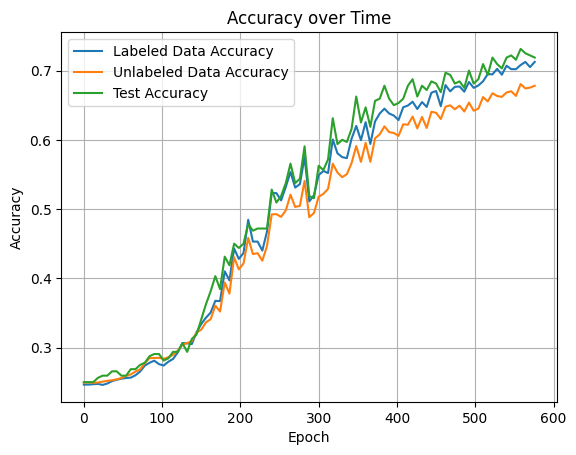

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labeled_train_acc=labeled_train_acc[:-2]
unlabeled_train_acc=unlabeled_train_acc[:-2]
test_data_acc=test_data_acc[:-2]

print(len(labeled_train_acc))
print(len(unlabeled_train_acc))
print(len(test_data_acc))

num_epoch = len(labeled_train_acc)
labeled_train_acc = [labeled_train_acc[j] for j in range(0, num_epoch, 6) ]
unlabeled_train_acc = [unlabeled_train_acc[j] for j in range(0, num_epoch, 6) ]
test_data_acc = [test_data_acc[j] for j in range(0, num_epoch, 6) ]

epochs =[e*6 for e in list( range(len(labeled_train_acc)))]  # X-axis: epochs or steps

plt.plot(epochs, labeled_train_acc, label='Labeled Data Accuracy')
plt.plot(epochs, unlabeled_train_acc, label='Unlabeled Data Accuracy')
plt.plot(epochs, test_data_acc, label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()
%reset -f